# Imports

In [1]:
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import cmocean
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import scipy.signal
import copy
import dask.distributed
import pandas as pd
import os

## (optional) remove gridlines from plots
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

# Helper fns

In [2]:
def plot_setup(fig, projection, lon_range, lat_range, xticks=None, yticks=None):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## increase resolution for projection
    ## (otherwise lines plotted on surface won't follow curved trajectories)
    projection.threshold /= 1000

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines(linewidths=0.5)

    ## add tick labels
    if xticks is not None:

        ## add lon/lat labels
        gl = ax.gridlines(
            draw_labels=True,
            linestyle="-",
            alpha=0.1,
            linewidth=0.5,
            color="k",
            zorder=1.05,
        )

        ## specify which axes to label
        gl.top_labels = False
        gl.right_labels = False

        ## specify ticks
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xlocator = mticker.FixedLocator(xticks)

    return ax


def plot_box_outline(ax, lon_range, lat_range, c="k"):
    """
    Plot box outlining the specifed lon/lat range on given
    ax object.
    """

    ## get width and height
    height = lat_range[1] - lat_range[0]
    width = lon_range[1] - lon_range[0]

    ## add rectangle to plot
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lon_range[0], lat_range[0]],
            height=height,
            width=width,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            edgecolor=c,
            linewidth=1,
        )
    )

    return ax


def plot_correlation(plot_setup_fn, corr, x, y):
    """
    Make spatial plot of correlation, using the specified
    plot setup function and pre-computed correlation.
    Args:
        - plot_setup_fn: function that returns a fig, ax object
        - corr: xarray with spatial correlation
        - x, y: lon/lat points for plotting
    """

    ## blank canvas to plot on
    fig = plt.figure()

    ## draw background map of Atlantic
    fig, ax = plot_setup_fn(fig)

    ## plot the data
    plot_data = ax.contourf(
        x,
        y,
        corr,
        transform=ccrs.PlateCarree(),
        levels=make_cb_range(1, 0.1),
        extend="both",
        cmap="cmo.balance",
    )

    ## create colorbath
    colorbar = fig.colorbar(plot_data, label="Corr.", ticks=[-1, -0.5, 0, 0.5, 1])

    return fig, ax


def plot_setup_pacific(fig):
    """Plot Atlantic region"""

    ## adjust figure size
    fig.set_size_inches(5, 3)

    ## specify map projection
    proj = ccrs.PlateCarree(central_longitude=-160)

    ## get ax object
    ax = plot_setup(
        fig,
        proj,
        lon_range=[100, 300],
        lat_range=[-30, 30],
        xticks=[150, -160, -110],
        yticks=[-20, 0, 20],
    )

    return fig, ax


def make_cb_range(amp, delta):
    """Make colorbar_range for cmo.balance
    Args:
        - 'amp': amplitude of maximum value for colorbar
        - 'delta': increment for colorbar
    """
    return np.concatenate(
        [np.arange(-amp, 0, delta), np.arange(delta, amp + delta, delta)]
    )


def plot_setup_timeseries():
    """
    Create fig, ax objects and label time axis
    """

    ## set up plot
    fig, ax = plt.subplots(figsize=(4, 3))

    ## restrict to last 50 years and label axes
    ax.set_xlim([datetime.date(1970, 1, 1), None])

    ax.set_xticks(
        [
            datetime.date(1979, 1, 1),
            datetime.date(2000, 6, 30),
            datetime.date(2021, 12, 31),
        ]
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    return fig, ax


def plot_seasonal_cycle(mean, std):
    """
    Plot the seasonal cycle (monthly mean ± 1 standard dev.)
    """

    ## plot
    fig, ax = plt.subplots(figsize=(4, 3))

    ## mean
    ax.plot(np.arange(1, 13), mean, c="k", label=r"$\mu$")

    ## mean ± std
    ax.plot(np.arange(1, 13), mean + std, c="k", lw=0.5, label=r"$\mu \pm \sigma$")
    ax.plot(np.arange(1, 13), mean - std, c="k", lw=0.5)

    ## label

    ax.legend()

    return fig, ax


def spatial_avg(data):
    """function to compute spatial average of data on grid with constant
    longitude/latitude spacing."""

    ## first, compute cosine of latitude (after converting degrees to radians)
    latitude_radians = np.deg2rad(data.latitude)
    cos_lat = np.cos(latitude_radians)

    ## get weighted average using xarray
    avg = data.weighted(weights=cos_lat).mean(["longitude", "latitude"])

    return avg


def get_trend_coefs(data, dim="time", deg=1):
    """get coefficients for trend"""
    return data.polyfit(dim=dim, deg=deg)["polyfit_coefficients"]


def get_trend(data, dim="time", deg=1):
    """
    Get trend for an xr.dataarray along specified dimension,
    by fitting polynomial of degree 'deg'.
    """

    ## Get coefficients for best fit
    polyfit_coefs = get_trend_coefs(data=data, dim=dim, deg=deg)

    ## Get best fit line (linear trend in this case)
    trend = xr.polyval(data[dim], polyfit_coefs)

    return trend


def detrend(data, dim="time", deg=1):
    """
    Remove trend of degree 'deg' from data, along dimension 'dim'.
    """

    return data - get_trend(data, dim=dim, deg=deg)


def get_empirical_pdf(x, bin_edges=None):
    """
    Estimate the "empirical" probability distribution function for the data x.
    In this case the result is a normalized histogram,
    Normalized means that integrating over the histogram yields 1.
    Returns the PDF (normalized histogram) and edges of the histogram bins
    """

    ## compute histogram
    if bin_edges is None:
        hist, bin_edges = np.histogram(x)

    else:
        hist, _ = np.histogram(x, bins=bin_edges)

    ## normalize to a probability distribution (PDF)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf = hist / (hist * bin_width).sum()

    return pdf, bin_edges


def get_gaussian_best_fit(x):
    """Get gaussian best fit to data, and evaluate
    probabilities over the range of the data."""

    ## get normal distribution best fit
    gaussian = scipy.stats.norm(loc=x.mean(), scale=x.std())

    ## evaluate over range of data
    amp = np.max(np.abs(x.values))
    x_eval = np.linspace(-amp, amp)
    pdf_eval = gaussian.pdf(x_eval)

    return pdf_eval, x_eval


def swap_longitude_range(data):
    """swap longitude range of xr.DataArray from [0,360) to (-180, 180]"""

    ## copy of longitude coordinate to be modified
    new_longitude = copy.deepcopy(data.lon.values)

    ## find index where longitude first exceeds 180.
    ## (note: np.argmax returns first instance of "True" in boolean array)
    swap_idx = np.argmax(new_longitude > 180)

    ## relabel values >180
    new_longitude[swap_idx:] = -360 + new_longitude[swap_idx:]

    ## add this coordinate back to the array
    data["lon"] = new_longitude

    ## "roll" the data to be centered at zero
    data = data.roll({"lon": -swap_idx}, roll_coords=True)

    return data


def get_autocorr_helper(x, lag, month=None):
    """Get autocorrelation of data for single lag"""

    ## return 1 for a lag of 0
    if lag == 0:
        return 1.0

    ## get lagged version of x
    elif lag > 0:
        x_lagged = x.isel(time=slice(lag, None))
        x_ = x.isel(time=slice(None, -lag))

    else:
        x_lagged = x.isel(time=slice(None, lag))
        x_ = x.isel(time=slice(-lag, None))

    ## re-label time axis so arrays match
    x_lagged["time"] = x_.time

    ## subset for data from given month
    if month is not None:
        is_month = x_.time.dt.month == month
        x_ = x_.isel(time=is_month)
        x_lagged = x_lagged.isel(time=is_month)

    return get_corr_coef(x_, x_lagged).item()


def get_autocorr(x, lags, month=None):
    """Get autocorrelation for data for multiple lags"""

    ## put autocorrelation for each lag in array
    autocorr = [get_autocorr_helper(x, lag, month) for lag in lags]

    ## convert to xr.DataArray
    return xr.DataArray(autocorr, coords={"lag": lags})


def get_autocorr_by_month(x, lags):
    """Get autocorrelation for each month, and stack in array"""

    ## compute autocorrelation for each month
    autocorr = [get_autocorr(x, lags, month=m) for m in np.arange(1, 13)]

    ## convert to xarray
    return xr.concat(autocorr, dim=pd.Index(np.arange(1, 13), name="month"))


def load_simulation(varname, member_id, simulation_type, preprocess_func=None):
    """
    Load dataset for single simulation, for single variable.
    Arguments:
        - varname: name of variable to load, one of {"SST","PSL"}
        - member_id: ID of ensemble member to load, an integer in the range [1,10]
        - simulation_type: one of {"hist", "rcp85"}
        - preprocess func: optional preprocessing function to apply to the simulation
    Returns:
        - xarray dataarray with given data
    """

    ## Filepath to the CESM LENS dataset
    lens_fp = pathlib.Path("cmip6/data/cmip6/CMIP/NCAR/LENS")

    #### 1. get filepath to data
    data_fp = SERVER_FP / lens_fp / pathlib.Path(varname)

    #### 2. get naming pattern for files to open
    if simulation_type == "hist":
        file_pattern = f"*20TRC*.{member_id:03d}.*.nc"

    elif simulation_type == "rcp85":
        file_pattern = f"*RCP85*.{member_id:03d}.*.nc"

    else:
        print("Not a valid simulation type")

    #### 3. open the relevant datasets, applying preprocessing function
    data = xr.open_mfdataset(
        paths=data_fp.glob(file_pattern),
        preprocess=preprocess_func,
        chunks={"time": 60},
    )

    return data[varname].squeeze(drop=True)


def load_ensemble_helper(varname, simulation_type, preprocess_func=None):
    """
    Load all ensemble members for given simulation type and variable.
    Arguments:
        - varname: name of variable to load, one of {"SST","PSL"}
        - simulation_type: one of {"hist", "rcp85"}
        - preprocess func: optional preprocessing function to apply to the simulation
    Returns:
        - xarray dataarray with given data and 'ensemble' dimension
    """

    ## put arguments in dictionary
    kwargs = dict(
        varname=varname,
        simulation_type=simulation_type,
        preprocess_func=preprocess_func,
    )

    ## put results in list
    data = [load_simulation(member_id=i, **kwargs) for i in np.arange(1, 11)]

    ## concatenate data along the "ensemble" dimension
    ensemble_dim = pd.Index(np.arange(1, 11), name="member")
    data = xr.concat(data, dim=ensemble_dim)

    return data


def load_ensemble(varname, simulation_type, lat_range, preprocess_func=None, save_fp=None):
    """
    Load all ensemble members for given simulation type and variable.
    (Checks if data exists locally first).
    Arguments:
        - varname: name of variable to load, one of {"SST","PSL"}
        - simulation_type: one of {"hist", "rcp85"}
        - preprocess func: optional preprocessing function to apply to the simulation
        - save_fp: pathlib.Path object (save the result here if specified)
    Returns:
        - xarray dataarray with given data and 'ensemble' dimension
    """

    ## put arguments in dictionary
    kwargs = dict(
        varname=varname,
        simulation_type=simulation_type,
        preprocess_func=preprocess_func,
    )

    ## load pre-computed data if it exists
    if save_fp is not None:

        ## path to file
        save_fp = save_fp / f"{varname}_{simulation_type}_{lat_range}.nc"

        ## check if file exists:
        if save_fp.is_file():
            data = xr.open_dataarray(save_fp)

        else:

            ## load the data and save to file for next time
            data = load_ensemble_helper(**kwargs)

            print("saving to file")
            data.to_netcdf(save_fp)

    else:

        ## don't load/save the data
        data = load_ensemble_helper(**kwargs)

    return data


def preprocess(data):
    """
    Preprocessing steps:
        1. remove data before Feb 1920
        2. trim in lon/lat space
        3. convert time dimension from cftime to datetime
    """

    ## trim in time
    data_ = data.sel(time=slice("1920-02", None))

    ## trim in space
    data_ = trim(data_)

    ## update time dimension
    start_year = data_.time.isel(time=0).dt.year.item()
    start_month = data_.time.isel(time=0).dt.month.item()
    start_date = f"{start_year}-{start_month}-01"
    data_["time"] = pd.date_range(start=start_date, periods=len(data_.time), freq="MS")

    return data_

In [3]:
def swap_longitude_range_TLONG(data):
    """swap longitude range of xr.DataArray from [0,360) to (-180, 180].
    Handles case with 2-dimension longitude coordinates ('TLONG')"""

    ## make copy of longitude coordinate to be modified
    TLONG_new = copy.deepcopy(data.TLONG.values)

    ## relabel values greater than 180
    exceeds_180 = TLONG_new > 180
    TLONG_new[exceeds_180] = -360 + TLONG_new[exceeds_180]

    ## Update the coordinate on the xarray object
    data["TLONG"].values = TLONG_new

    ## next, transpose data so that longitude is last dimension
    ## (we'll do all the sorting along this dimension)
    data = data.transpose(..., "nlon")

    ## Get indices needed to sort longitude to be monotonic increasing
    TLONG_sort_idx = np.argsort(data["TLONG"].values, axis=-1)

    ## sort the lon/lat coordindates
    sort = lambda X, idx: np.take_along_axis(X.values, indices=idx, axis=-1)
    data["TLONG"].values = sort(data["TLONG"], idx=TLONG_sort_idx)
    data["TLAT"].values = sort(data["TLAT"], idx=TLONG_sort_idx)

    #### sort the SST data

    # first, check to see if data has more than two dimensions
    
    if data.ndim > 2:
        extra_dims = [i for i in range(data.ndim - 2)]
        TLONG_sort_idx = np.expand_dims(TLONG_sort_idx, axis=extra_dims)
    
    ## now, do the actual sorting
    data.values = sort(data, idx=TLONG_sort_idx)

    return data

In [31]:
def trim(data, lon_range=[0,360], lat_range=[45,90]):
    """select part of data in given longitude/latitude range"""

    ## check if data is on the "T"-grid
    on_Tgrid = "TLONG" in data.coords

    ## handle trimming for T-grid
    if on_Tgrid:

        ## helper function to check if 'x' is in 'x_range'
        isin_range = lambda x, x_range: (x_range[0] <= x) & (x <= x_range[1])
        
        ## get mask for data in given lon/lat range
        in_lon_range = isin_range(data['TLONG'],lon_range)
        in_lat_range = isin_range(data["TLAT"], lat_range)
        
        in_lonlat_range = in_lon_range & in_lat_range

        ## load to memory
        in_lonlat_range.load()

        ## Retain all points with at least one valid grid cell
        x_idx = in_lonlat_range.any("nlat")
        y_idx = in_lonlat_range.any("nlon")

        ## select given points
        return data.isel(nlon=x_idx, nlat=y_idx)

    else:
        return data.sel(lon=slice(*lon_range), lat=slice(*lat_range))

# Load, trim, save data

In [5]:
## Path to file server
SERVER_FP = pathlib.Path("/Volumes/")

## Specify folder location for saving trimmed data ("./" means current directory)
save_fp = pathlib.Path("./hw4/")

In [92]:
## Load data

#this is janky because all these data products have different lat ranges; load one at a time and change trim

lens_SH_S = load_ensemble("SST", "hist", "90-45", preprocess_func=preprocess, save_fp=save_fp) #lat -90 to -45
#lens_SH_N = load_ensemble("SST", "hist", "45-0", preprocess_func=preprocess, save_fp=save_fp) #lat -45 to 0
#lens_NH_S = load_ensemble("SST", "hist", "0-45", preprocess_func=preprocess, save_fp=save_fp) #lat 0 to 45
#lens_NH_N = load_ensemble("SST", "hist", "45-90", preprocess_func=preprocess, save_fp=save_fp) #lat 45 to 90

In [93]:
#swapping longitude range to -180, 180
lens_SH_S = swap_longitude_range_TLONG(lens_SH_S)

# plot data sample

In [14]:
def plot_setup_global(fig):
    """Plot Atlantic region"""

    ## adjust figure size
    fig.set_size_inches(5, 3)

    ## specify map projection
    proj = ccrs.PlateCarree(central_longitude=0)

    ## get ax object
    ax = plot_setup(
        fig,
        proj,
        lon_range=[-180, 180],
        lat_range=[-90, 90],
        xticks=[-200, -100, 0, 100, 200],
        yticks=[-90, -45, 0, 45, 90],
    )

    return fig, ax

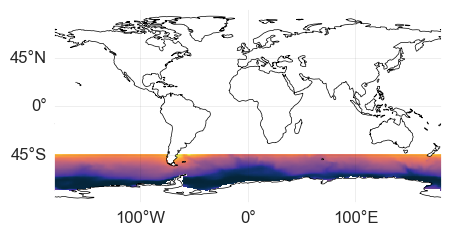

In [98]:
fig = plt.figure(figsize=(10, 3))

## make background of trop. Pacific
fig, ax = plot_setup_global(fig)

## plot the data

plot_data = ax.pcolormesh( 
    lens_SH_S.TLONG,
    lens_SH_S.TLAT,
    lens_SH_S.isel(member=0, time=0),
    cmap="cmo.thermal",
    #vmax=30,
    #vmin=15,
    transform=ccrs.PlateCarree(),
)


# timeseries

'''
 In LENS, you could isolate the effect of external forcing by averaging over all ensemble members.
 After ensemble-averaging, you could remove a linear trend (implicitly representing non-volcanic external
 forcing) and the seasonal cycle; hopefully, the resulting anomalies are dominated by the volcanic forcing. 
 So the resulting anomalies would be your “residual” timeseries, called R(t) in the paper. 
 Once you have this R(t), you could try to reproduce some of the plots in the 
 paper (e.g., their Figs 3a and 3b).
 '''

In [74]:
lens_NH_N

<xarray.DataArray 'SST' (member: 10, time: 1032, nlat: 88, nlon: 320)> Size: 1GB
array([[[[ 6.1714654,  6.409254 ,  6.641641 , ...,  5.508767 ,
           5.701619 ,  5.9308877],
         [ 5.962803 ,  6.2009654,  6.431469 , ...,  5.2793922,
           5.487598 ,  5.720693 ],
         [ 5.795445 ,  6.029639 ,  6.256287 , ...,  5.1239643,
           5.333153 ,  5.5599766],
         ...,
         [       nan,        nan,        nan, ..., -1.8051182,
          -1.805047 , -1.8050616],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[ 5.3459506,  5.549849 ,  5.7686324, ...,  4.7786174,
           4.967882 ,  5.1580434],
         [ 5.126778 ,  5.3425894,  5.5662   , ...,  4.524051 ,
           4.7222357,  4.9219418],
         [ 4.9498615,  5.1751485,  5.3989587, ...,  4.336378 ,
           4.5322995,  4.7373257],
...
         [       nan,        nan,        nan, ..., -1.8024379,
          -1.8026195, -1.8025088],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[ 7.2633977,  7.4689126,  7.6392617, ...,  6.6042905,
           6.818077 ,  7.0397224],
         [ 6.836858 ,  7.0450554,  7.2246394, ...,  6.180149 ,
           6.3948684,  6.6143794],
         [ 6.4675946,  6.6763277,  6.8586497, ...,  5.8185716,
           6.0271077,  6.245787 ],
         ...,
         [       nan,        nan,        nan, ..., -1.8068093,
          -1.8072352, -1.807028 ],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 225kB 44.16 44.11 44.07 ... 76.93 76.78 76.86
    TLONG    (nlat, nlon) float64 225kB -179.1 -178.0 -176.8 ... -22.66 -22.65
    ULAT     (nlat, nlon) float64 225kB 37.65 37.65 37.65 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 225kB 321.1 322.2 323.3 ... 319.2 319.6 320.0
  * time     (time) datetime64[ns] 8kB 1920-02-01 1920-03-01 ... 2006-01-01
  * member   (member) int64 80B 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [99]:
#ensemble averaging
ensemble_mean = lens_NH_N.mean(["member"])

#remove linear trend


#remove seasonal cycle
data_deseason = ensemble_mean.groupby("time.month") - ensemble_mean.groupby("time.month").mean()


In [100]:
data_deseason = data_deseason.mean(["nlon","nlat"])

In [96]:
ensemble_mean = ensemble_mean.mean(['nlon','nlat'])

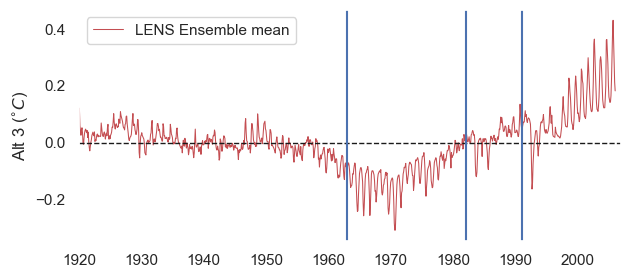

In [106]:
## plot ensemble mean
fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(
    lens_NH_N.time,
    data_deseason,
    c="r",
    lw=0.75,
    zorder=2,
    label="LENS Ensemble mean",
)


## label
ax.set_ylabel(r"Alt 3 ($^{\circ}C$)")
ax.legend()
ax.axhline(0, ls="--", c="k", lw=1)
ax.set_xlim([datetime.datetime(1920, 1, 1), datetime.datetime(2006, 12, 31)])

ax.axvline(datetime.datetime(1982,1,1))
ax.axvline(datetime.datetime(1963,1,1))
ax.axvline(datetime.datetime(1991,1,1))

plt.show()